## Imports

In [1]:
import sys

import corner
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
from arviz.labels import MapLabeller
from multiprocessing import Pool
from eryn.ensemble import EnsembleSampler
from eryn.moves import CombineMove, GaussianMove, StretchMove, MTDistGenMoveRJ, DistributionGenerateRJ
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State
from eryn.utils import TransformContainer
from eryn.utils.utility import groups_from_inds

from sklearn.model_selection import KFold, train_test_split
from scipy.stats import norm, invgamma

sys.path.append("../../TFM/rk-bfr")
seed = 42
rng = np.random.default_rng(seed)
np.random.seed(seed)

import utils.simulation_utils as simulation
from utils import plot_utils

%matplotlib inline

## Dataset

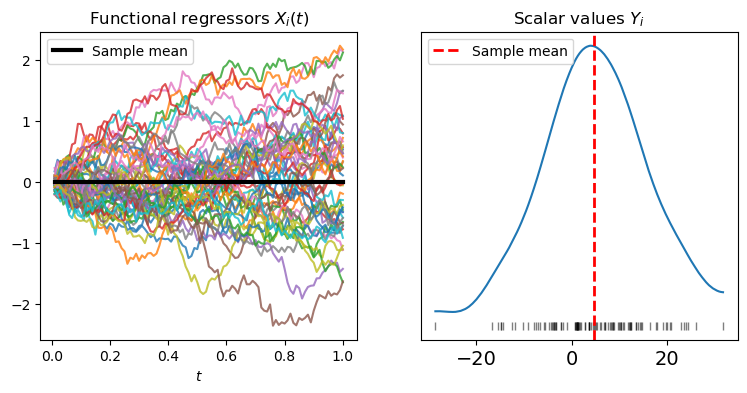

In [2]:
# define true parameters
component_params = np.array(
    [
        [-5, 0.1],
        [5, 0.6],
        [10, 0.8],
    ]
)
alpha0 = 5
sigma2 = 0.5

# define dataset parameters
ngrid = 100
n_train, n_test = 100, 50
mean_vector = np.zeros(ngrid)
kernel_fn = simulation.brownian_kernel

# generate regressors and response
t = np.linspace(1.0 / ngrid, 1, ngrid)
x = simulation.gp(t, mean_vector, kernel_fn, n_train + n_test, rng=rng)
y = simulation.generate_rkhs_dataset(
    x, t, component_params.T[0], component_params.T[1], alpha0, sigma2, rng=rng
)
y_noiseless = simulation.generate_rkhs_dataset(
    x, t, component_params.T[0], component_params.T[1], alpha0, 0.0, rng=rng
)

# Train/test split and standardize
indices = np.arange(n_train + n_test)  # for future convenience
X, X_test, Y, Y_test, idx_train, idx_test = train_test_split(x, y, indices, train_size=n_train, random_state=seed)
X, X_test = simulation.standardize_predictors(X, X_test)
#Y, Y_test = simulation.standardize_response(Y, Y_test)

# Plot dataset
plot_utils.plot_dataset_regression(
    X,
    Y,
    n_samples=n_train//2,
)

## Model RKHS

### Likelihood

**TODO likelihood**

  Vectorize and check if it is faster

In [3]:
def log_likelihood(theta, t, X, y):
    """
    - theta is a list [theta_leaves, theta_common]
        * theta_leaves is an array (p, 2) of the parameters (b_j, t_j) for each component (leaf), where 1<=p<=p_max.
        * theta_common is an array (1, 2) of the parameters alpha_0 and sigma^2, which are common for all models (leaves).
    - t is the grid of shape (ngrid,)
    - X,y are the data, of shape (nfunc, ngrid) and (nfunc,) respectively.
    """
    n = X.shape[0]
    theta_leaves, theta_common = theta
    beta = theta_leaves[:, 0]
    tau = theta_leaves[:, 1]
    alpha0 = theta_common[0][0]
    sigma2 = theta_common[0][1]

    if sigma2 < 0 or np.any(tau < t.min()) or np.any(tau > t.max()):
        return -np.inf

    idx = np.abs(t - tau[:, np.newaxis]).argmin(axis=1)
    X_tau = X[:, idx]
    diff = y - alpha0 - X_tau @ beta
    ll = -n * np.log(np.sqrt(sigma2)) - 0.5*np.einsum('i,i->', diff, diff) / sigma2
  
    return ll

def log_likelihood_vectorize(theta, t, X, y):
    """
    - theta is a list [theta_leaves, theta_common]
        * theta_leaves is an array (p, 2) of the parameters (b_j, t_j) for each component (leaf), where 1<=p<=p_max.
        * theta_common is an array (1, 2) of the parameters alpha_0 and sigma^2, which are common for all models (leaves).
    - t is the grid of shape (ngrid,)
    - X,y are the data, of shape (nfunc, ngrid) and (nfunc,) respectively.
    """
    n = X.shape[0]
    theta_leaves, theta_common = theta
    beta = theta_leaves[:, 0]
    tau = theta_leaves[:, 1]
    alpha0 = theta_common[0][0]
    sigma2 = theta_common[0][1]

    if sigma2 < 0 or np.any(tau < t.min()) or np.any(tau > t.max()):
        return -np.inf

    idx = np.abs(t - tau[:, np.newaxis]).argmin(axis=1)
    X_tau = X[:, idx]
    diff = y - alpha0 - X_tau @ beta
    ll = -n * np.log(np.sqrt(sigma2)) - 0.5*np.einsum('i,i->', diff, diff) / sigma2
  
    return ll

### Prior

**TODO prior**

1. Prior multivariante en beta FOR ALL LEAVES (parámetro especial prior_all_models)
2. Prior en los beta y en sigma2 escalado según los datos. ¿CÓMO?

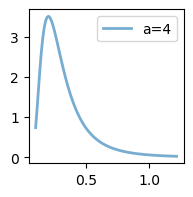

In [4]:
aa=4
plt.figure(figsize=(2, 2))
x = np.linspace(invgamma.ppf(0.01, aa),
                invgamma.ppf(0.99, aa), 100)
plt.plot(x, invgamma.pdf(x, aa),
        lw=2, alpha=0.6, label=f"a={aa}")
_ = plt.legend()

In [15]:
class flat_dist():
    def logpdf(self, x):
        return 0

# describes priors for all leaves independently on each branch
# the prior on p (the number of components) is assumed to be uniform in [n_leaves_min,n_leaves_max]
sigma2_param = 2
priors = {
    "components": ProbDistContainer({
        0: uniform_dist(-50, 50),  # beta
        1: uniform_dist(t.min(), t.max()),  # tau
    }),
    "common": ProbDistContainer({
        0: flat_dist(),  # alpha0
        1: invgamma(sigma2_param)  # sigma2
    })
}

## Sampler

**TODO sampler**

1. Scale of ball around the estimate Y.mean() depends on the data. Same problem as with the prior above.
2. Tune parameters of moves on-the-fly?
3. GroupStretchMove or GaussianMove (does this use the ensemble capabilities?).
4. Check acceptance rate and use it to select optimal scaling parameters on the moves (far from 0 and 1)
5. RJMCMC move (?) --> sample from conditional distribution on the rest of the parameters.
6. Multiple Try RJMCMC --> num_try?
7. Label switching; order component means (?)

In [55]:
# set up chain parameters
branch_names = ["components", "common"]
nleaves_max = {"components": 5, "common": 1}
nleaves_min = {"components": 1, "common": 1}
ndims = {"components": 2, "common": 2}
nwalkers = 32
ntemps = 6

# set coordinates for the leaf values in both branches
coords = {
    branch: np.zeros((ntemps, nwalkers, nleaf, ndim))
    for nleaf, ndim, branch in zip(nleaves_max.values(), ndims.values(), branch_names)
}

# sample initial values for components (b,t) and sigma2 from prior
coords["components"] = priors["components"].rvs(size=(ntemps, nwalkers, nleaves_max["components"]))
coords["common"][:, :, 0, 1] = invgamma(sigma2_param).rvs(size=(ntemps, nwalkers))

# set initial values for alpha0
scale_alpha0 = 0.5
coords["common"][:, :, 0, 0] = norm(loc=Y.mean(), scale=scale_alpha0).rvs(size=(ntemps, nwalkers))

# set indices for used/unused leaves of components (boolean 0/1) 
# we need to ensure that not all components are zero on any (ntemp,nwalkers), 
# because nleaves_min = 1
inds = {}
inds["components"] = np.random.randint(2, size=(ntemps, nwalkers, nleaves_max["components"]), dtype=bool)
idx = np.where(np.sum(inds["components"], axis=-1) == 0)
inds["components"][*idx, 0] = True

# set indices for the single leaf of [alpha0,sigma2] (always used) <-- IS THIS NECESSARY?
inds["common"] = np.ones((ntemps, nwalkers, nleaves_max["common"]), dtype=bool)

In [61]:
# number of steps
nsteps = 500
thin_by = 2
burn = 500

# number of cores
njobs = 8

# moves
factor = 0.0001
cov = {branch: np.diag(np.ones(ndims[branch])) * factor for branch in branch_names}
move_gaussian = GaussianMove(cov)

move_stretch = StretchMove()

# rj moves
num_try = 2
rjmoveMT = MTDistGenMoveRJ(  # multiple-try distgen from prior
    {"components": priors["components"]},
    nleaves_max={branch: value for branch, value in zip(branch_names, nleaves_max.values())},
    nleaves_min={branch: value for branch, value in zip(branch_names, nleaves_min.values())},
    gibbs_sampling_setup="components",  # only perform RJ on the components
    num_try=num_try,
    rj=True,
)

rjmove = DistributionGenerateRJ(  # distgen from prior
    {"components": priors["components"]},
    nleaves_max={branch: value for branch, value in zip(branch_names, nleaves_max.values())},
    nleaves_min={branch: value for branch, value in zip(branch_names, nleaves_min.values())},
    gibbs_sampling_setup="components",  # only perform RJ on the components
)

# re-set random seed for reproducible sampling
np.random.seed(42)

# sample
with Pool(njobs) as pool:
    ensemble = EnsembleSampler(
        nwalkers,
        ndims,
        log_likelihood,
        priors,
        args=[t, X, Y],
        pool=pool,
        tempering_kwargs=dict(ntemps=ntemps),
        nbranches=len(branch_names),
        branch_names=branch_names,
        nleaves_max=nleaves_max,
        nleaves_min=nleaves_min,
        moves=move_stretch,
        rj_moves=rjmoveMT,
    )

    # setup starting state
    state = State(coords, inds=inds)

    # run the sampler
    print("Sampling posterior distribution...")
    last_sample = ensemble.run_mcmc(
        state, nsteps, burn=burn, progress=True, thin_by=thin_by
    )

/home/antcc/.micromamba/envs/python-scientific/lib/python3.11/site-packages/eryn/ensemble.py:442: UserWarning: If using revisible jump, using the Stretch Move for in-model proposals is not advised. It will run and work, but it will not be using the correct complientary group of parameters meaning it will most likely be very inefficient.
  warnings.warn(


Sampling posterior distribution...


100%|██████████| 1000/1000 [00:30<00:00, 32.42it/s]


In [62]:
### print(last_sample.branches["components"].nleaves)
print(last_sample.branches["components"].inds[0, 0, :])
print(last_sample.branches_coords["components"][0,0, :])
print(last_sample.branches_coords["common"][0,0, :])

[False  True  True False  True]
[[ 0.03308937  0.03147973]
 [ 4.63062307  0.59567547]
 [10.31632899  0.79965843]
 [ 0.24751997  0.04618341]
 [-5.16121768  0.10258392]]
[[4.66859719 1.18954992]]


In [63]:
print("Acceptance % (T=1)\n", 100*ensemble.acceptance_fraction[0])
print("RJ Acceptance % (T=1)\n", 100*ensemble.rj_acceptance_fraction[0])

Acceptance % (T=1)
 [3.  1.4 3.4 1.6 2.  2.6 3.4 3.2 3.  6.  0.6 2.4 4.  3.4 3.2 2.4 1.  3.2
 4.8 3.4 2.8 2.8 3.  3.6 3.2 4.6 1.4 3.2 3.4 3.6 2.8 3.4]
RJ Acceptance % (T=1)
 [0.6 0.8 0.6 0.8 2.  1.6 1.2 0.4 1.2 0.2 1.4 1.4 0.6 0.6 1.  1.4 1.2 1.4
 2.2 1.4 1.2 1.6 2.  0.6 1.2 1.6 0.4 1.8 0.2 1.  1.2 0.8]


Posterior distribution p|D of the number of components accross all walkers


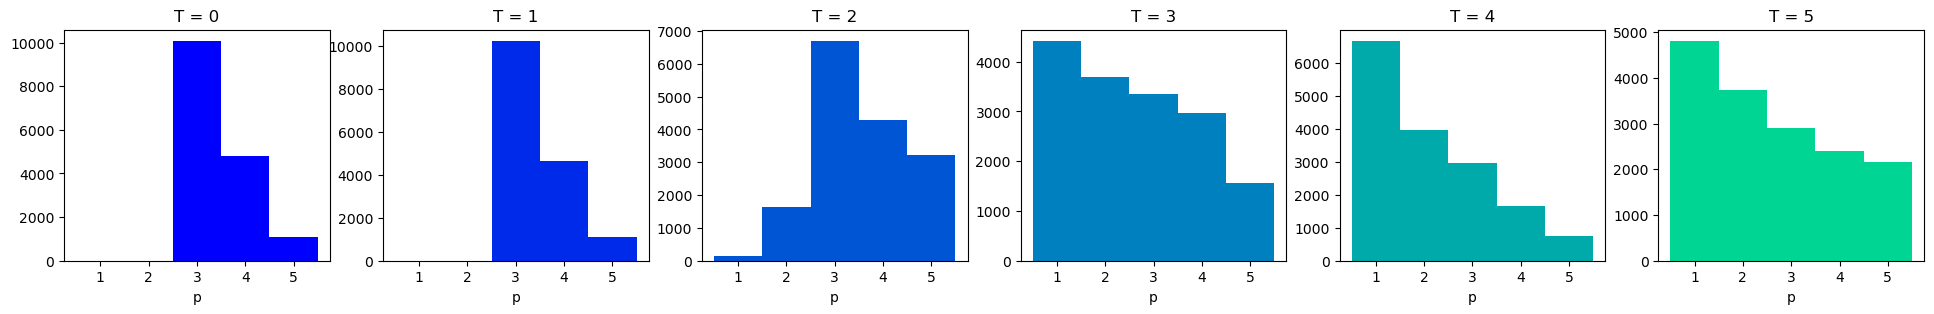

In [64]:
print("Posterior distribution p|D of the number of components accross all walkers")

nleaves = ensemble.get_nleaves()["components"]
bins = (
    np.arange(1, nleaves_max["components"] + 2) - 0.5
)
colors = plt.get_cmap('winter')

fig, ax = plt.subplots(1, ntemps, figsize=(4 * ntemps, 3))
for temp, ax_t in enumerate(ax):
    color = colors(temp/ntemps)
    ax_t.set_title("T = " + str(temp))
    ax_t.set_xlabel("p")
    ax_t.hist(nleaves[:, temp].flatten(), bins=bins, color=color)

**TODO** hacer los plots bonitos con todas las variables.

Posterior distribution and trace accross all walkers (T=1)


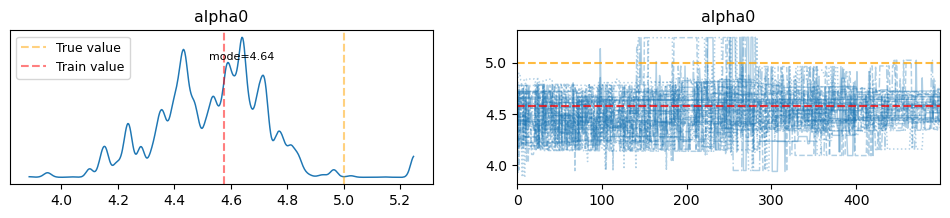

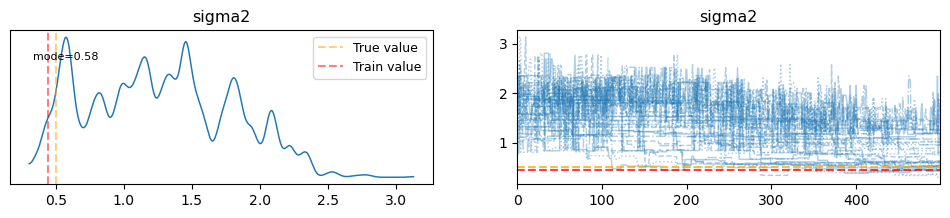

In [65]:
def plot_trace(chain_eryn, T=0, var_name="x", true_value=None, train_value=None):
    # Get chain (nwalkers, nsamples)
    chain = chain_eryn[:, T].swapaxes(0, 1)
    
    # Compute mode
    arr, density = az.kde(chain)
    mode = arr[np.argmax(density)]

    # Plot marginal posterior and trace
    ax = az.plot_trace(
        chain,
        combined=True,
        labeller=MapLabeller({"x": var_name}),
    )

    # Plot reference values 
    plot_height = ax[0, 0].get_ylim()[1]
    if true_value:
        ax[0, 0].axvline(
            x=true_value, color="orange", linestyle="--", alpha=0.5, label="True value"
        )
        ax[0, 1].axhline(y=true_value, color="orange", linestyle="--", alpha=0.75)
        
    if train_value:
        ax[0, 0].axvline(
            x=train_value, color="red", linestyle="--", alpha=0.5, label="Train value"
        )
        ax[0, 1].axhline(y=train_value, color="red", linestyle="--", alpha=0.75)
        
    ax[0, 0].text(
        mode,
        plot_height * 0.8,
        f"mode={mode:.2f}",
        horizontalalignment="center",
        fontsize=8,
    )
    if true_value or train_value:
        ax[0, 0].legend(fontsize=9)

# Get chain from sampler
common = ensemble.get_chain(discard=0)["common"].squeeze()
alpha0_chain = common[..., 0]
sigma2_chain = common[..., 1]

# Plot trace
print("Posterior distribution and trace accross all walkers (T=1)")
plot_trace(alpha0_chain, 0, "alpha0", alpha0, Y.mean())
plot_trace(sigma2_chain, 0, "sigma2", sigma2, np.var(y[idx_train] - y_noiseless[idx_train]))